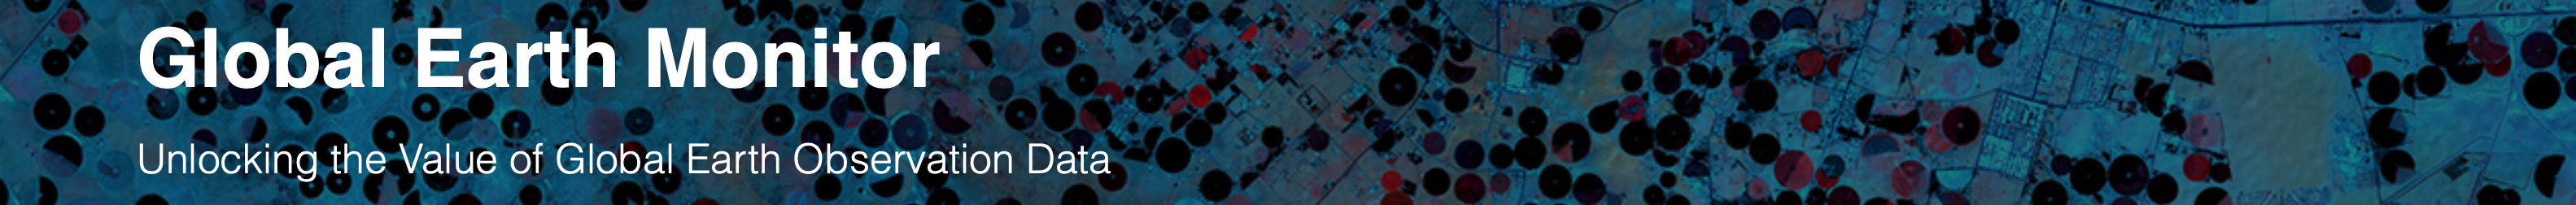

<hr>

The Global Earth Monitor (GEM) project is addressing the challenge of continuous monitoring of large areas in a sustainable cost-effective way. The goal of the project is to establish a new disruptive Earth Observation Data - Exploitation model which will dramatically enhance the exploitation of Copernicus data.

Read more about the project, and subscribe to our newsletter [here](https://www.globalearthmonitor.eu).

_This project has received funding from the European Union’s Horizon 2020 research and innovation programme under Grant Agreement No. 101004112._
    
<hr>

The example in this notebook shows how a typical Earth Observation workflow can be run using [`eo-grow`](https://github.com/sentinel-hub/eo-grow.git).

The workflow is depicted in the image below:
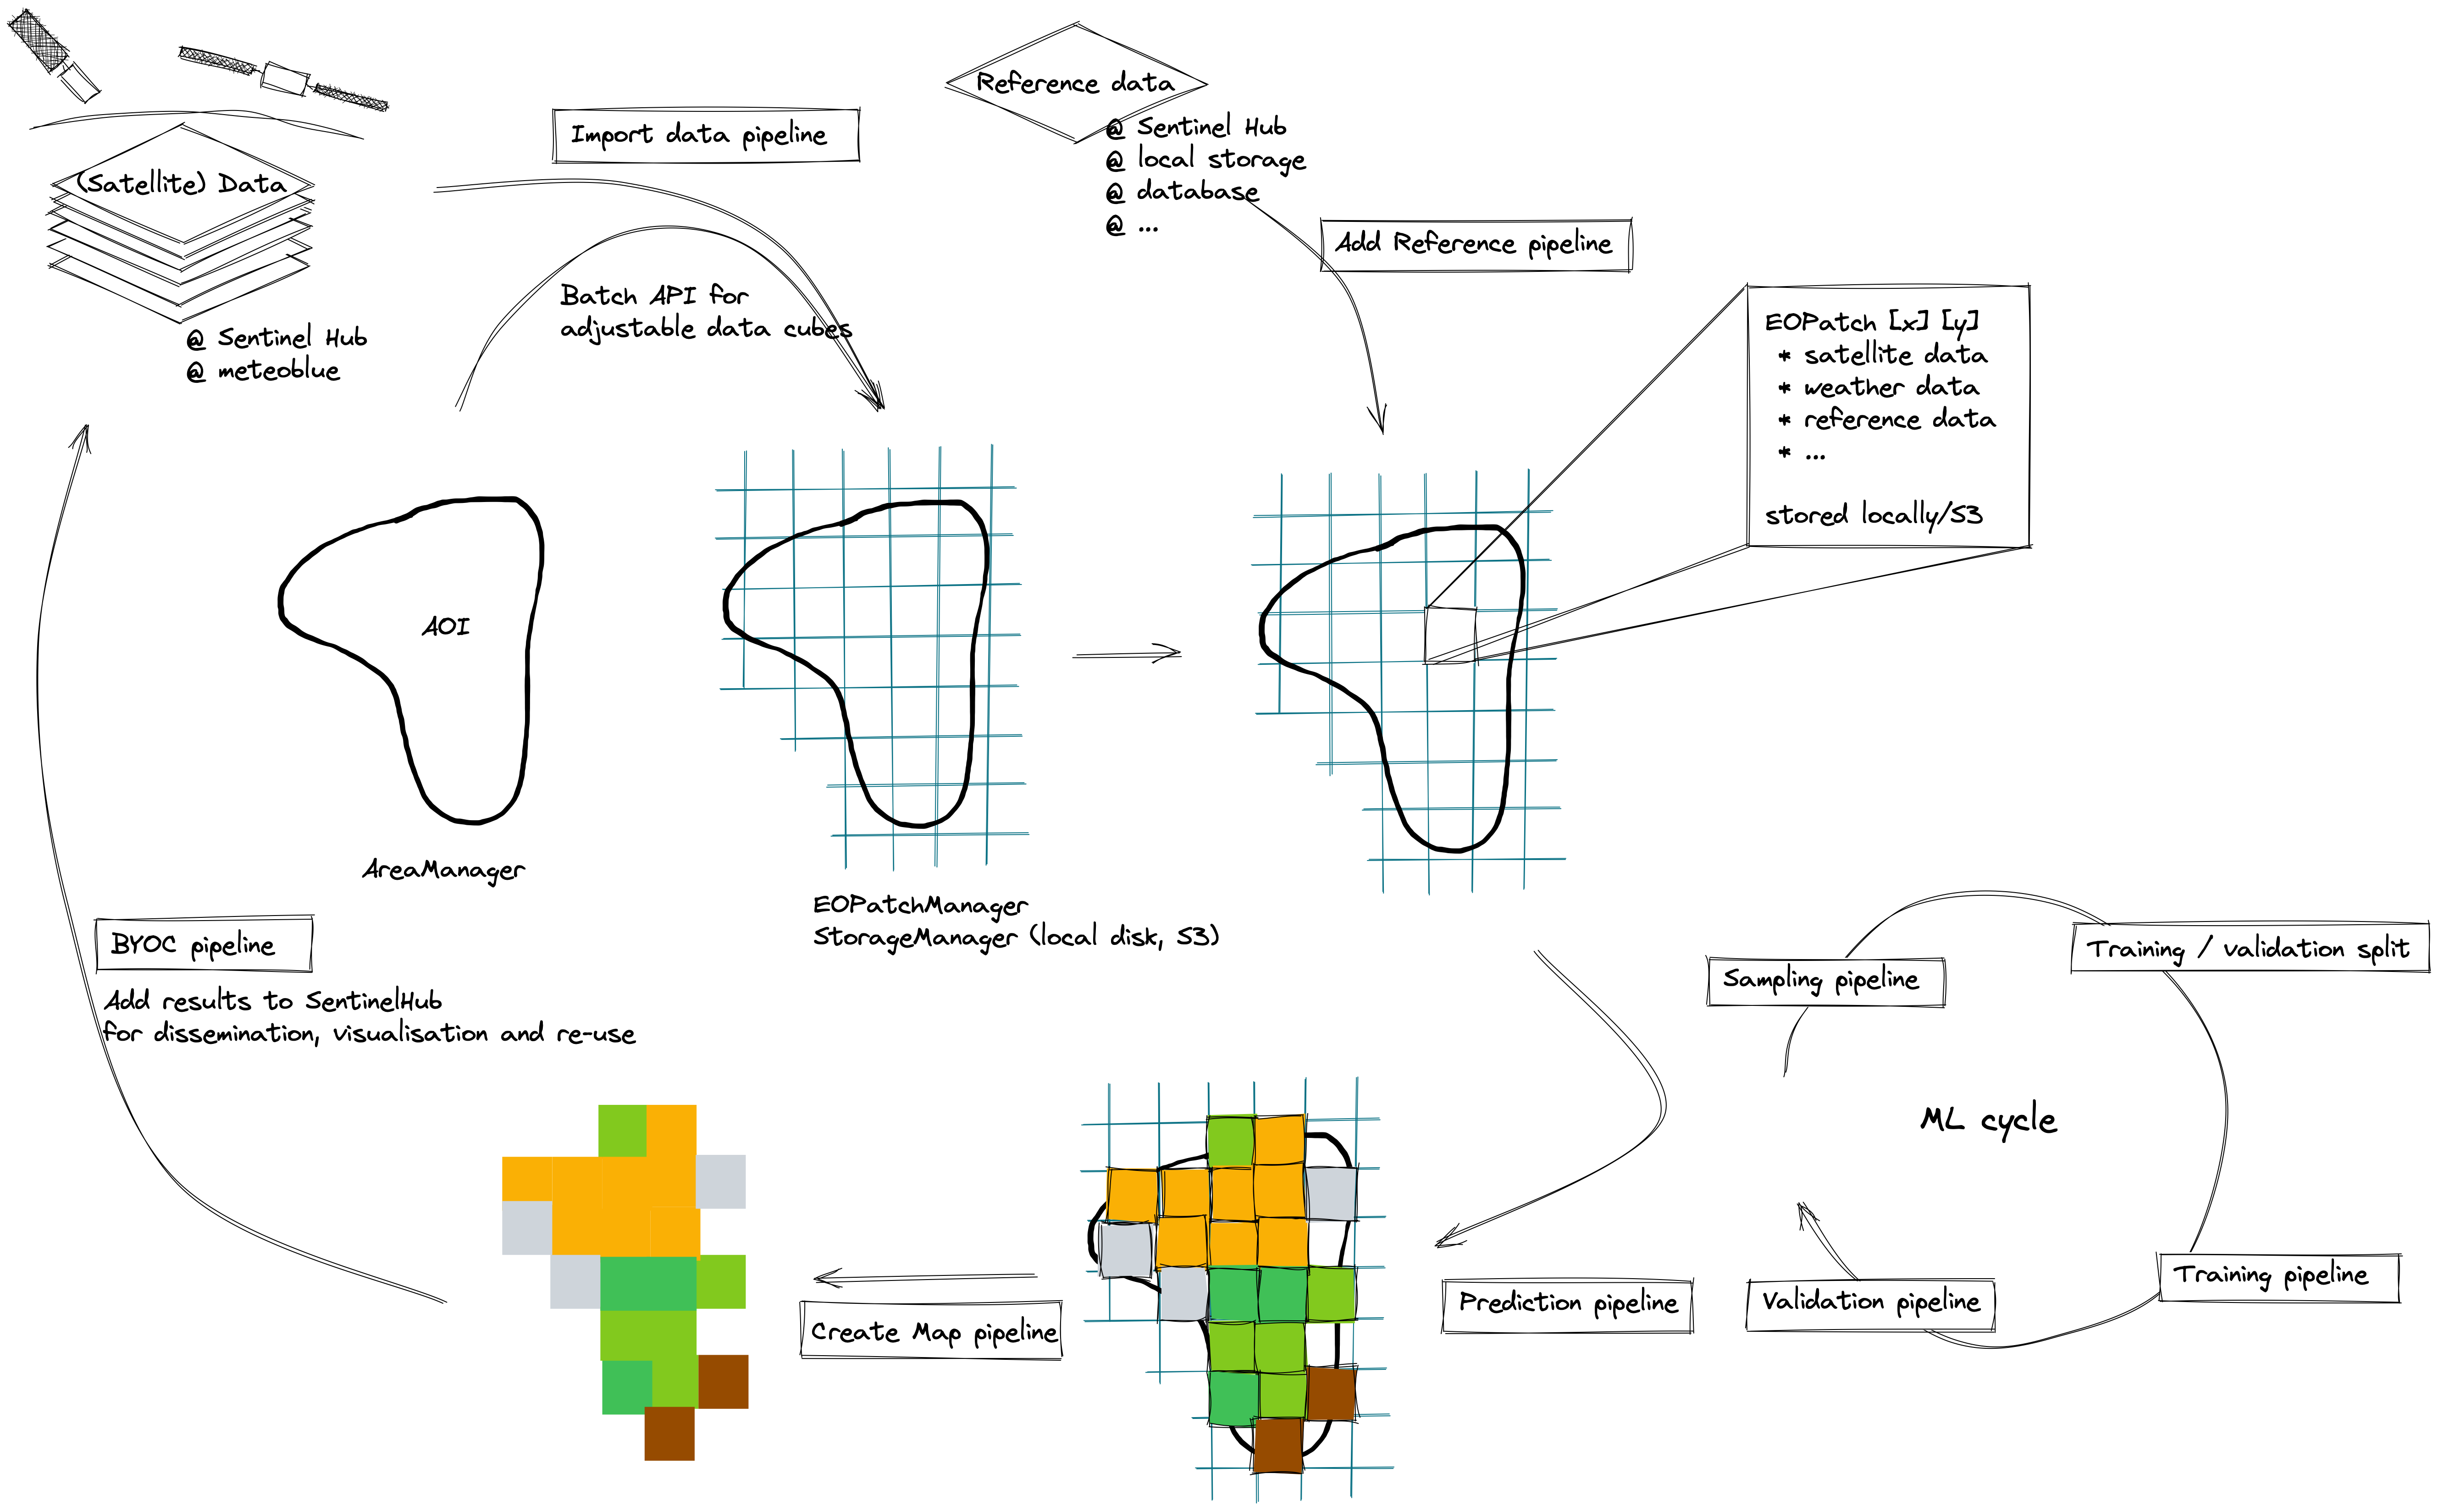

and skips the ML part for the sake of ease. The full example, with instructions on how to run it on large scale is given in [`eo-grow-examples`](https://github.com/sentinel-hub/eo-grow-examples.git).


## Pre-requisites

 * EOxHub Workspace subscription
 * Sentinel Hub subscription


## Configuration

To set up the workspace,first import the neccessary python libraries. These libraries are pre-installed in EOxHub Workspace. Additionally import environment variables which automatically includes Sentinel Hub credentials that will be used to configure Sentinel Hub API.


### Upgrade eo-grow to latest version

In [1]:
!pip install eo-grow --upgrade 

Defaulting to user installation because normal site-packages is not writeable


### Imports

In [47]:
%matplotlib inline

import os
from typing import Any, Dict
import warnings

import IPython

from eogrow.core.config import RawConfig, interpret_config_from_dict, recursive_config_join
from eogrow.core.storage import StorageManager
from eogrow.core.area import UtmZoneAreaManager
from eogrow.pipelines.download import DownloadEvalscriptPipeline
from eogrow.pipelines.features import FeaturesPipeline
from eogrow.pipelines.prediction import RegressionPredictionPipeline
from eogrow.pipelines.export_maps import ExportMapsPipeline
from eogrow.pipelines.byoc import IngestByocTilesPipeline

from sentinelhub import SHConfig

warnings.filterwarnings('ignore')

### Some helper functions

In [2]:
def prepare_config(global_config: Dict[str, Any], pipeline_config: Dict[str, Any]) -> RawConfig:
    joint_config = recursive_config_join(pipeline_config, global_config)
    return interpret_config_from_dict(joint_config)

### Credentials

Sentinel Hub credentials `SH_CLIENT_ID` and `SH_CLIENT_SECRET` are already imported as envornment variables. In the next step pass the credentials to `SHConfig()` object:

In [4]:
# Pass Sentinel Hub credentials to SHConfig
config = SHConfig()
config.sh_client_id = os.environ["SH_CLIENT_ID"]
config.sh_client_secret = os.environ["SH_CLIENT_SECRET"]

## Running the pipelines

### Define area of interest (AOI)

For this example the AOI is covering area around Porto Novo (Benin) and Lagos (Nigeria), as can be seen below.   
The AOI is stored in `project/input-data/demo-aoi.geojson`, and is specified as input parameter in the `AreaManager` part of the global config (below).

In [51]:
IPython.display.GeoJSON(filename='./project/input-data/demo-aoi.geojson')

<IPython.display.GeoJSON object>

### Config with global parameters

The main configuration parameters are defined here: a folder, where everything (data, model, results, ...) will be stored. In this case, the project folder is local path; it could also be a path on object storage (AWS S3). As it is local, one can also copy the notebook and corresponding files under `project` to local machine and run things there.  

In [52]:
PROJECT_FOLDER = os.path.join(os.path.abspath(os.path.curdir), 'project')

In [17]:
storage_config = {
    "manager": "eogrow.core.storage.StorageManager",
    "project_folder": PROJECT_FOLDER,
    "structure": {
      "data": "data",
      "features": "features",
      "predictions": "predictions",
      "models": "models",
      "maps": "maps"
    }
}

area_config = {
    "manager": "eogrow.core.area.utm.UtmZoneAreaManager",
    "area_filename": "demo-aoi.geojson",
    "patch_size_x": 512*120,
    "patch_size_y": 512*120,
}

logging_config = {
    "manager": "eogrow.core.logging.LoggingManager",
    "save_logs": True,
    "show_logs": True,
    "capture_warnings": False
}

global_config = {
    "storage": storage_config,
    "area": area_config,
    "eopatch": {"manager": "eogrow.core.eopatch.EOPatchManager"},
    "logging": logging_config,
    "use_ray": False,
    "workers": 4
}

In [18]:
storage_manager = StorageManager.from_raw_config(storage_config)

### Download pipeline

As for this demonstration we are not using object storage (AWS S3), we will be requesting data through Sentinel Hub ProcessingAPI. When relying on object storage, we could have used the BatchAPI and corresponding `eogrow.pipelines.batch_download.BatchDownloadPipeline`.

This pipeline takes care of the first step in literally any EO workflow: getting the data.

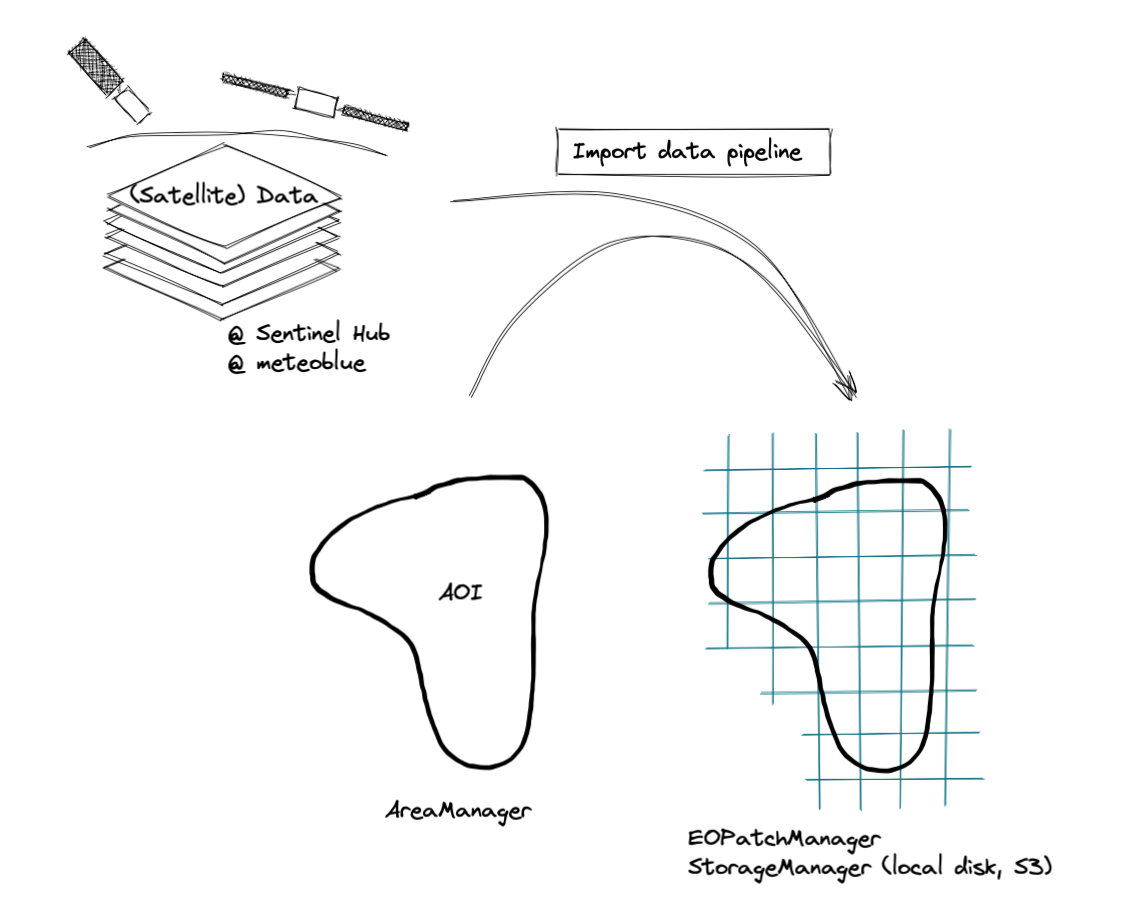

In [19]:
evalscript_path = os.path.join(storage_manager.get_input_data_folder(full_path=True), 'evalscript.js')

In [26]:
download_config = {
  "pipeline": "eogrow.pipelines.download.DownloadEvalscriptPipeline",
  "data_collection": {
    "name": "BYOC_484d8dbb-9e3e-41f2-b96b-35189d3ae37f",
  },
  "time_period": ["2020-01-01", "2021-01-01"],
  "resolution": 120,
  "resampling_type": "BILINEAR",
  "skip_existing": True,
  "output_folder_key": "data",
  "features": [["data", "BANDS"], ["mask", "QUALITY_MASK"]],
  "postprocessing": {
      "rescale_schemas": [{
          "rescale_factor": 0.0001,
          "dtype": "float",
          "features_to_rescale": [["data", "BANDS"]],
      }],
  },
  "evalscript_path": evalscript_path
}

In [27]:
download_pipeline = DownloadEvalscriptPipeline.from_raw_config(prepare_config(global_config, download_config))

In [28]:
download_pipeline.run()

INFO eogrow.core.pipeline:236: Running DownloadEvalscriptPipeline
INFO eogrow.core.area.base:206: Loading grid from cache/grid_demo-aoi_UtmZoneAreaManager___61440_61440_0.0_0.0_0.0_0.0.gpkg
INFO eogrow.core.pipeline:121: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO eogrow.core.pipeline:127: Skipped some EOPatches, 0 / 6 remaining
INFO eogrow.core.pipeline:193: Starting EOExecutor for 0 EOPatches


0it [00:00, ?it/s]

INFO eogrow.core.pipeline:208: EOExecutor finished with 0 / 0 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /home/jovyan/gem-eogrow-example/project/logs/2022-09-01T12-49-25Z-DownloadEvalscriptPipeline-d995a7bd7b/eoexecution-report-2022_09_01-07_49_27/report.html
INFO eogrow.core.pipeline:248: Pipeline finished successfully!


### Features pipeline

In this pipeline we are computing a (trivial) set of indices. With SentinelHub we could have easily retrieved them via apropriately tailored evalscript, reducing also the amout of requested data. 

In [29]:
features_config = {
  "pipeline": "eogrow.pipelines.features.FeaturesPipeline",
  "input_folder_key": "data",
  "output_folder_key": "features",
  "bands_feature_name": "BANDS",
  "data_preparation": {
    "valid_data_feature_name": "QUALITY_MASK" # because we won't do any filtering this features plays no role
  },
  "ndis": {
    "NDVI": [7,3],
    "NDWI": [2,7],
    "NDBI": [10,7]
  },
  "output_feature_name": "FEATURES",
  "dtype": "float",
  "skip_existing": True
}

In [30]:
features_pipeline = FeaturesPipeline.from_raw_config(prepare_config(global_config, features_config))

In [31]:
features_pipeline.run()

INFO eogrow.core.pipeline:236: Running FeaturesPipeline
INFO eogrow.core.area.base:206: Loading grid from cache/grid_demo-aoi_UtmZoneAreaManager___61440_61440_0.0_0.0_0.0_0.0.gpkg
INFO eogrow.core.pipeline:121: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO eogrow.core.pipeline:127: Skipped some EOPatches, 0 / 6 remaining
INFO eogrow.core.pipeline:193: Starting EOExecutor for 0 EOPatches


0it [00:00, ?it/s]

INFO eogrow.core.pipeline:208: EOExecutor finished with 0 / 0 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /home/jovyan/gem-eogrow-example/project/logs/2022-09-01T12-49-33Z-FeaturesPipeline-6cce54e809/eoexecution-report-2022_09_01-07_49_36/report.html
INFO eogrow.core.pipeline:248: Pipeline finished successfully!


### Prediction pipeline

As specified, this workflow is a slimmed down version of the full example, available on `eo-grow-examples`. As such, we are skipping the training part, and will continue straight with the prediction pipeline, using the model that is the result from the full example. For ease of use, the model is included in this example at `project/models/`.

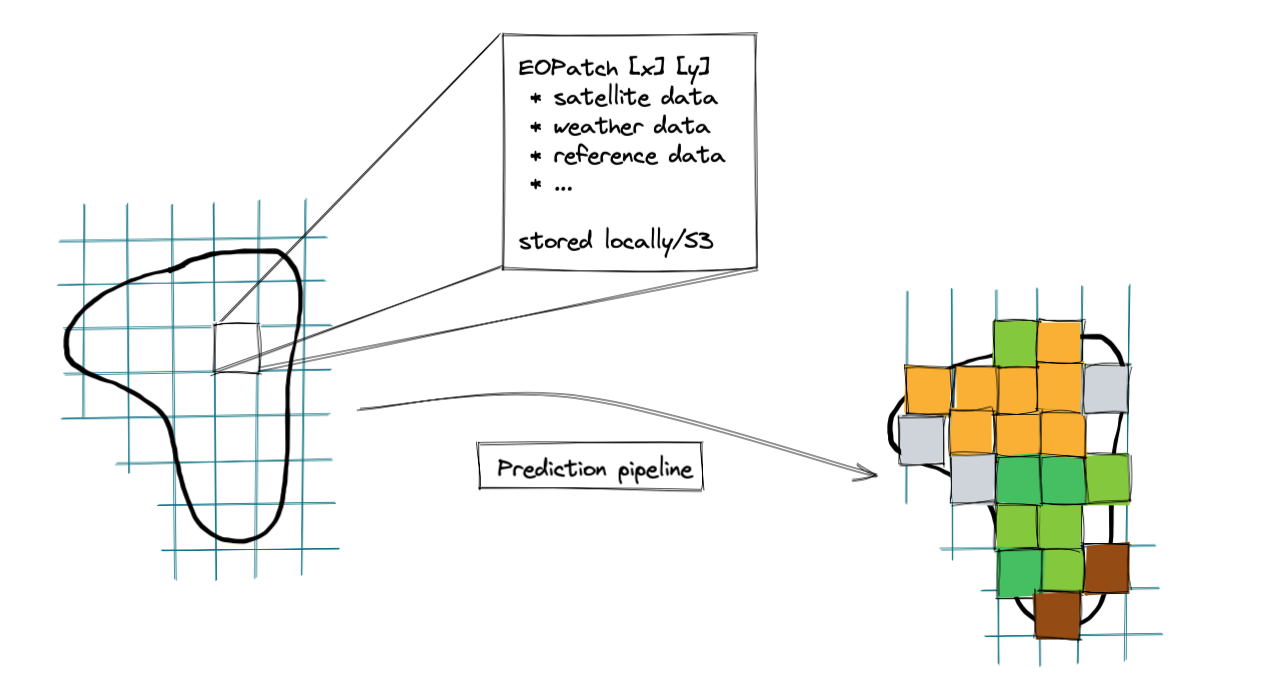

In [32]:
prediction_config = {
  "pipeline": "eogrow.pipelines.prediction.RegressionPredictionPipeline",
  "input_folder_key": "features",
  "model_folder_key": "models",
  "output_folder_key": "predictions",
  "input_features": [["data", "FEATURES"]],
  "output_feature_name": "test_prediction",
  "dtype": "float32",
  "model_filename": "gem-example_model.gz",
  "clip_predictions": [0, 100],
  "skip_existing": True
}

In [33]:
prediction_pipeline = RegressionPredictionPipeline.from_raw_config(prepare_config(global_config, prediction_config))

In [34]:
prediction_pipeline.run()

INFO eogrow.core.pipeline:236: Running RegressionPredictionPipeline
INFO eogrow.core.area.base:206: Loading grid from cache/grid_demo-aoi_UtmZoneAreaManager___61440_61440_0.0_0.0_0.0_0.0.gpkg
INFO eogrow.core.pipeline:121: Checking which EOPatches can be skipped


Checking EOPatches:   0%|          | 0/6 [00:00<?, ?it/s]

INFO eogrow.core.pipeline:127: Skipped some EOPatches, 0 / 6 remaining
INFO eogrow.core.pipeline:193: Starting EOExecutor for 0 EOPatches


0it [00:00, ?it/s]

INFO eogrow.core.pipeline:208: EOExecutor finished with 0 / 0 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /home/jovyan/gem-eogrow-example/project/logs/2022-09-01T12-49-36Z-RegressionPredictionPipeline-181232f564/eoexecution-report-2022_09_01-07_49_38/report.html
INFO eogrow.core.pipeline:248: Pipeline finished successfully!


### Export predictions to maps pipeline

This pipeline takes care of exporting final results as cloud-optimised-geotiffs (see parameter `cofigy=True` in config below). 

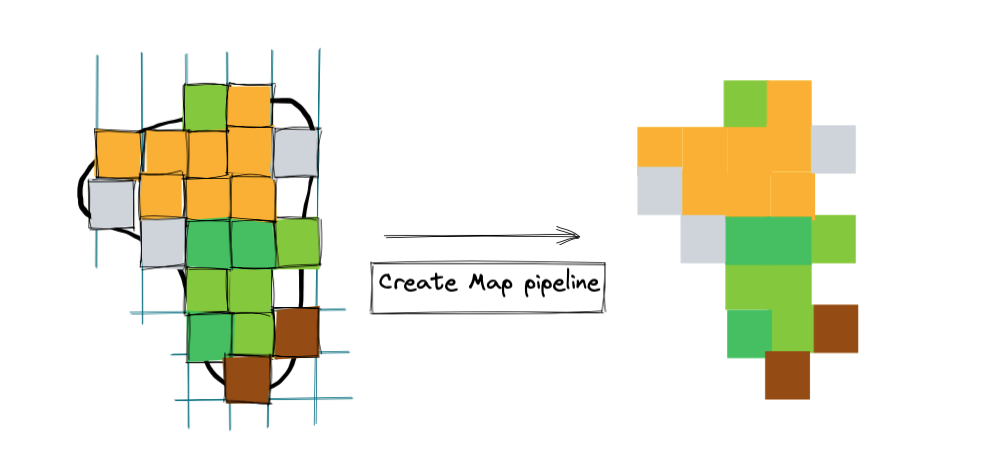

In [35]:
export_map_config = {
  "pipeline": "eogrow.pipelines.export_maps.ExportMapsPipeline",
  "input_folder_key": "predictions",
  "output_folder_key": "maps",
  "feature": ["data_timeless", "test_prediction"],
  "map_name": "result.tiff",
  "map_dtype": "uint8",
  "band_indices": [0],
  "cogify": True,
  "workers": 1
}

In [36]:
export_pipeline = ExportMapsPipeline.from_raw_config(prepare_config(global_config, export_map_config))

In [37]:
export_pipeline.run()

INFO eogrow.core.pipeline:236: Running ExportMapsPipeline
INFO eogrow.core.area.base:206: Loading grid from cache/grid_demo-aoi_UtmZoneAreaManager___61440_61440_0.0_0.0_0.0_0.0.gpkg
INFO eogrow.core.pipeline:193: Starting EOExecutor for 6 EOPatches


  0%|          | 0/6 [00:00<?, ?it/s]

INFO eogrow.core.pipeline:208: EOExecutor finished with 6 / 6 success rate
INFO eogrow.core.pipeline:217: Saved EOExecution report to /home/jovyan/gem-eogrow-example/project/logs/2022-09-01T12-49-40Z-ExportMapsPipeline-7aff87405f/eoexecution-report-2022_09_01-07_49_42/report.html
INFO eogrow.utils.map:150: merging 6 tiffs to /home/jovyan/gem-eogrow-example/project/maps/test_prediction/UTM_32631/result.tiff
0...10...20...30...40...50...60...70...80...90...100 - done.
INFO eogrow.utils.map:154: merging done
INFO eogrow.utils.map:85: cogifying /home/jovyan/gem-eogrow-example/project/maps/test_prediction/UTM_32631/result.tiff
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 1536, 1024
0...10...20...30...40...50...60...70...80...90...100 - done.
INFO eogrow.utils.map:88: cogifying done


Warning 1: General options of gdal_translate make the COPY_SRC_OVERVIEWS creation option ineffective as they hide the overviews


INFO eogrow.pipelines.export_maps:160: Merged map is saved at /home/jovyan/gem-eogrow-example/project/maps/test_prediction/UTM_32631/result.tiff


Deleting temp tiffs:   0%|          | 0/6 [00:00<?, ?it/s]

INFO eogrow.pipelines.export_maps:165: Cleaned original temporary maps
INFO eogrow.core.pipeline:248: Pipeline finished successfully!


### Ingest results to BYOD on Sentinel Hub

The following code would ingest the results back to the Sentinel Hub services (using [Bring Your Own Data](https://docs.sentinel-hub.com/api/latest/api/byoc/)) if we were using object storage (AWS S3 bucket) for project's storage.

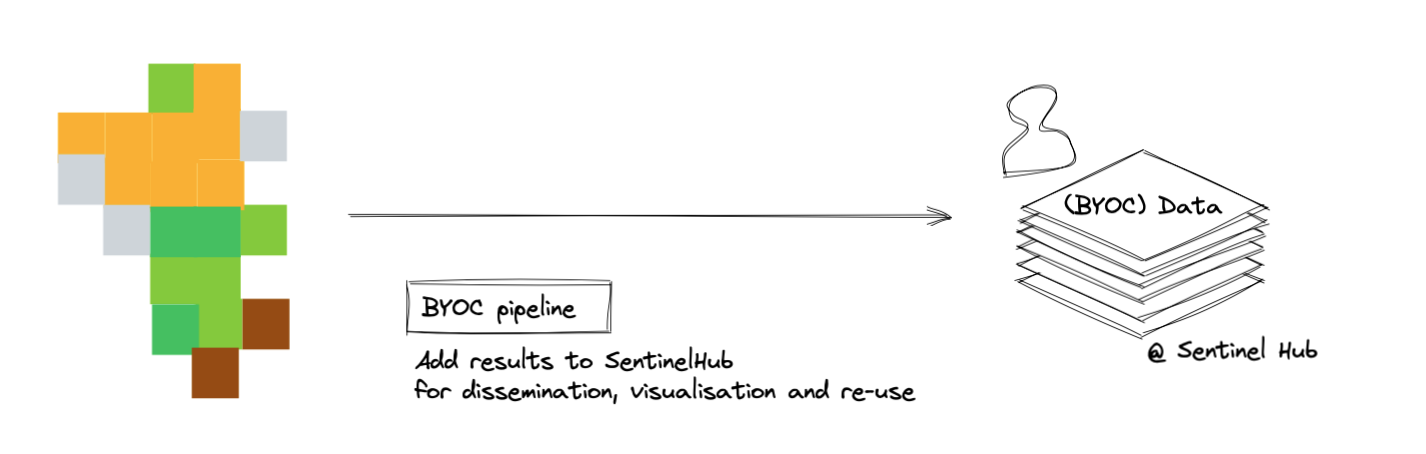


```python
ingestion_config = {
  "pipeline": "eogrow.pipelines.byoc.IngestByocTilesPipeline",
  "byoc_tile_folder_key": "maps",
  "new_collection_name": "GEM eo-grow example predictions over Lagos",
  "sensing_time": "2020-12-31",
  "cover_geometry_folder_key": "input_data",
  "cover_geometry": "demo-aoi.geojson"
}

ingestion_pipeline = IngestByocTilesPipeline.from_raw_config(prepare_config(global_config, ingestion_config))
ingestion_pipeline.run()
```

### Visualize the results

As we cannot use BYOC functinality in this (non object storage based) example, we'll rely on eo-learn and matplotlib to quickly visualize the results of built-up areas in the AOI. 

In [38]:
import matplotlib.pyplot as plt
from eolearn.core import EOPatch
from tqdm.auto import tqdm as tqdm

  0%|          | 0/6 [00:00<?, ?it/s]

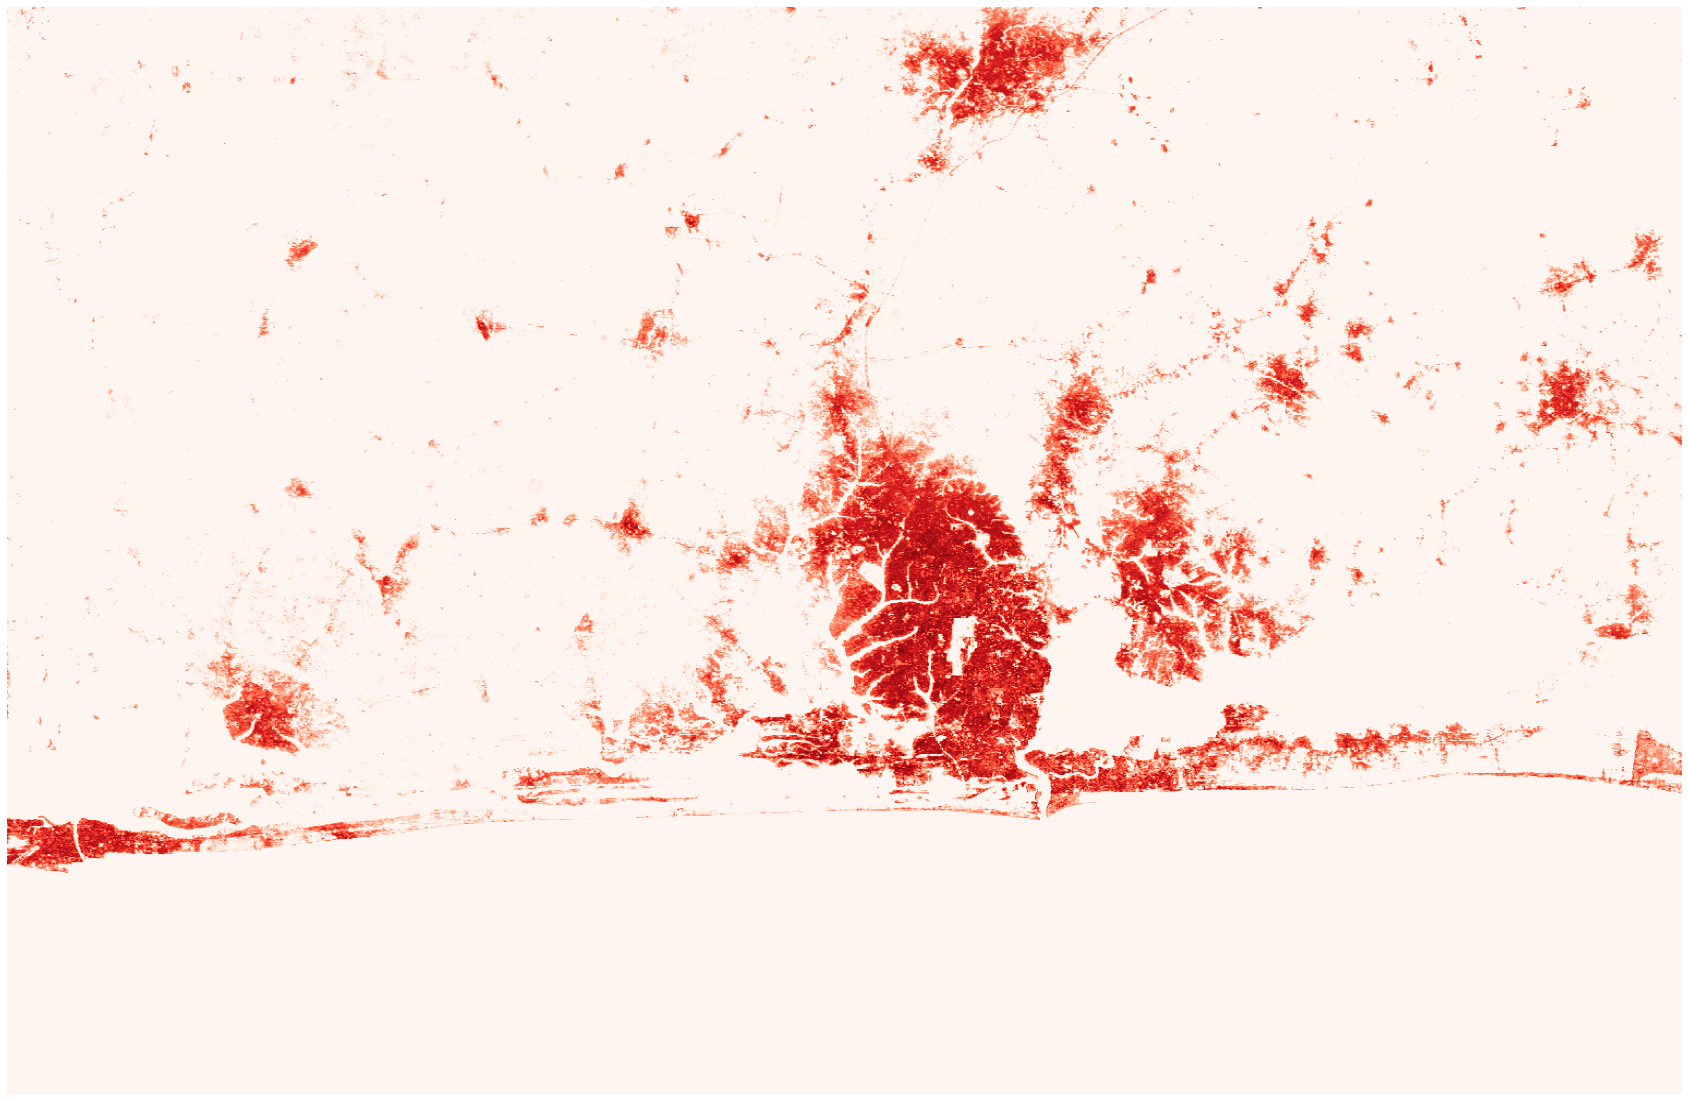

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(30, 20))

for eop_name in tqdm(download_pipeline.eopatch_manager.get_eopatch_filenames()):
    eopatch_path = os.path.join(storage_manager.get_folder('predictions', full_path=True), eop_name)
    eopatch = EOPatch.load(eopatch_path, lazy_loading=True)

    j, i = int(eop_name.split("-")[4]), int(eop_name.split("-")[6])
    ax = axs[1-i][j]
    ax.imshow(eopatch.data_timeless["test_prediction"].squeeze(), vmin=5, vmax=80, cmap='Reds')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect("auto")
    ax.set_axis_off()
    del eopatch

fig.subplots_adjust(wspace=0, hspace=0)